In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio


import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)

dpi = 300
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.ESPRIT_numpy import *

def RMS(x):
        return np.std(x)


def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Rapport_Final", "High_res", "preprocessing", "Figures")
figsize = (9/cm, 6/cm)

### Creating a basic modulated sine-wave

In [3]:
sr_hz = 22050
t = np.arange(2*sr_hz)
baseFreq = 440/sr_hz #Hz
modFreq = 1/sr_hz #Hz
modAmp = 100/sr_hz #Hz
sineAmp = 1
noiseAmp = .1

full_phase = baseFreq*t + modAmp/(2*np.pi*modFreq)*np.cos(2*np.pi*modFreq*t)
full_phase *= 2*np.pi
#x = sineAmp*np.sin(full_phase)
#x += noiseAmp*np.random.randn(np.shape(t)[0])


## Loading the audio file

In [4]:
#fileName = os.path.join('..', 'Data', 'Test', '69.wav')
#x, sr_hz = librosa.load(fileName)
#x = x[:2*sr_hz]

start_sec = .82
length_sec = 3

#start_sec = 0
#length_sec = 5

fileName = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM',
    'Medium_1', 'Corde_Acier', 'C_3_P_3_1.mat')
print(fileName)
data = scipy.io.loadmat(fileName)
print(data.keys())

sr_hz_old =  data['fs'][0,0]
x = data['acc_t'][int(sr_hz_old*start_sec):int(sr_hz_old*(start_sec+length_sec)),0].T
t = np.arange(len(x))/sr_hz_old

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_3_1.mat
dict_keys(['__header__', '__version__', '__globals__', 'FRF', 'acc_t', 'fen_acc', 'fen_mar', 'freq', 'fs', 'mar_t', 'None', 'signal_accelero_fen', 'signal_marteau_fen', 'time', '__function_workspace__'])


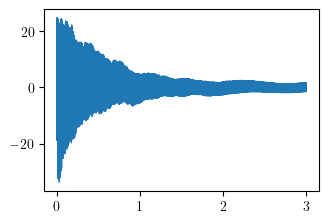

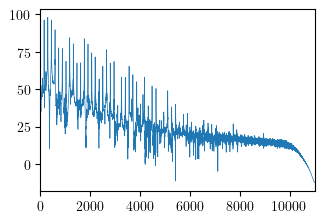

In [5]:
sr_hz = 22050
x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
t = np.arange(len(x))/sr_hz
plt.figure(figsize = figsize)
plt.plot(t,x)
plt.show()
plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz), dB20(np.fft.rfft(x)))
plt.xlim(0, sr_hz/2)
plt.show()

# Preprocessing

## Sub-band decomposition

## Whitening the noise

In [35]:
rankFilter_bins = 21
rankFilter_rank = .3

window_length = 512
hop_length = window_length
window_type = 'hann'

(257, 130)


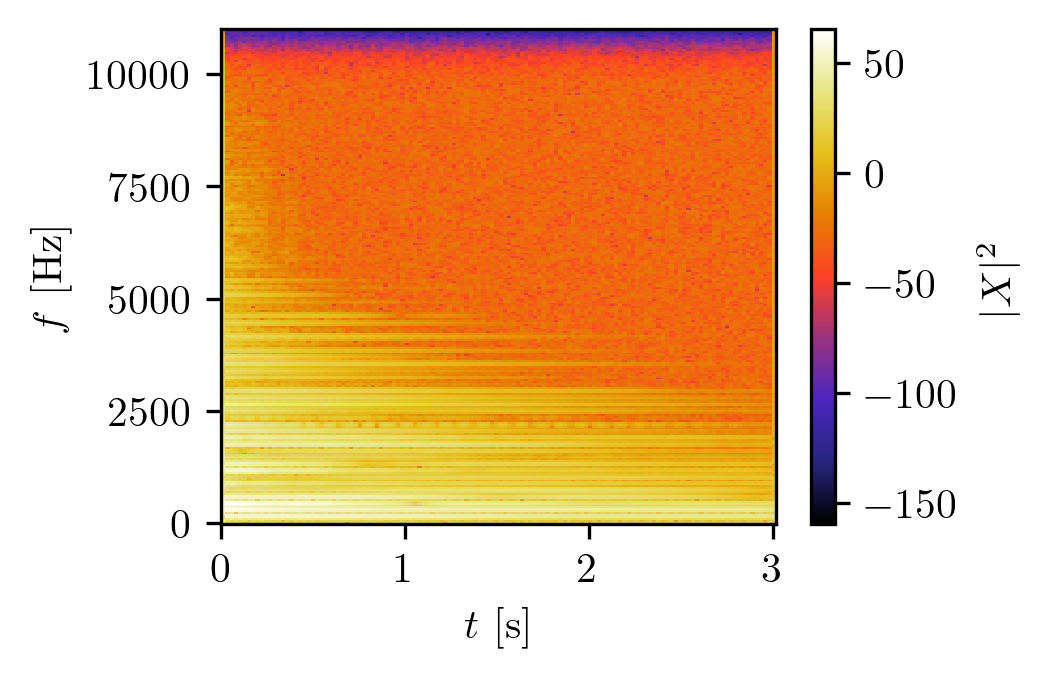

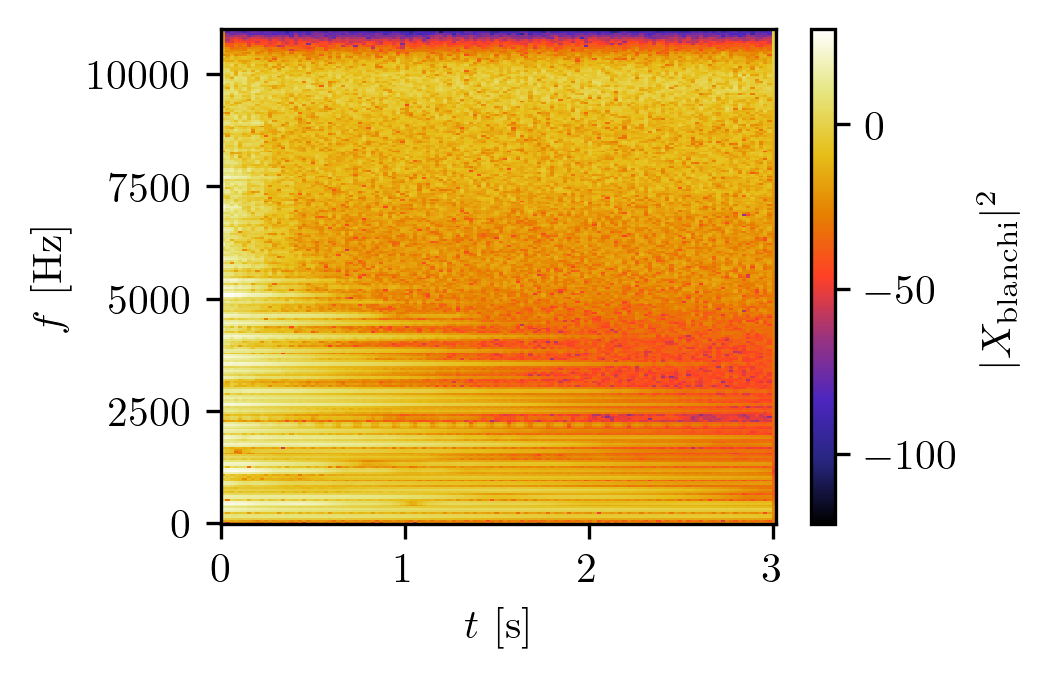

1


In [36]:


x_stft = librosa.stft(y=x, n_fft = window_length, hop_length = hop_length, window = window_type)
print(np.shape(x_stft))

t_list = librosa.frames_to_time(np.arange(np.shape(x_stft)[1]), sr = sr_hz, hop_length = hop_length, n_fft = window_length)
f_list = np.arange(np.shape(x_stft)[0])/np.shape(x_stft)[0]*sr_hz/2
xWhitened, ARFilters = whiten_signal(
    x = x,
    n_fft = window_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)

xWhitenedWindowed = window_signal(
    x = xWhitened,
    window_length = window_length,
    hop_length = hop_length,
)
xWindowed = window_signal(
    x = x,
    window_length = window_length,
    hop_length = hop_length,
)
xWhitened_stft = compute_stft_from_windowed(xWhitenedWindowed, window_type=window_type)

cmap = 'CMRmap'
dpi = 300

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "input_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(xWhitened_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = "$|X_{\mathrm{blanchi}}|^2$")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "whitened_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()

print(np.argmax(np.sum(np.abs(x_stft), axis = 0)))


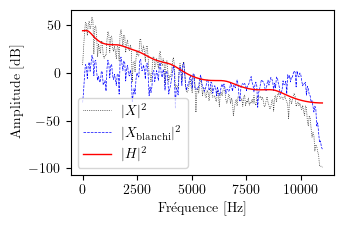

In [42]:
time_frame_display = np.argmax(np.sum(np.abs(x_stft), axis = 0))+20

plt.figure(figsize = figsize)
#plt.figure(figsize = (15, 5))
plt.plot(f_list, dB20(x_stft[:,time_frame_display]), 'k:', linewidth = .5, label = '$|X|^2$')
#plt.plot(f_list, dB10(xRankFiltered_stft[:,time_frame_display]), 'k--', linewidth = .5)
plt.plot(f_list, dB20(xWhitened_stft[:,time_frame_display]), 'b--', linewidth = .5, label = "$|X_{\mathrm{blanchi}}|^2$")
plt.plot(f_list, dB20(1/np.fft.rfft(ARFilters, n=window_length)), 'r-', linewidth = 1, label = "$|H|^2$")
plt.legend(ncols = 1)
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Amplitude [dB]")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "blanchissement_spectre.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()

32


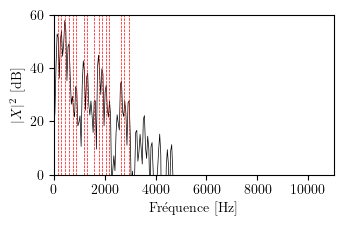

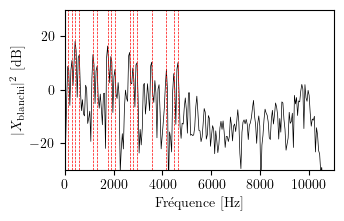

In [44]:
num_poles = 24

num_poles,_ = ESTER(xWhitenedWindowed[time_frame_display], max_poles = 250, factor = 20)
print(num_poles)
poles, complexAmp, Lambda = ESPRIT(xWindowed[time_frame_display], num_poles = num_poles)
freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]

plt.figure(figsize = figsize)
plt.plot(f_list, dB20(np.fft.rfft(xWindowed[time_frame_display]*np.hanning(window_length))), 'k')
for f in freqs:
    plt.axvline(f,0,1, color = 'r', linestyle = '--')
plt.xlabel("Fréquence [Hz]")
plt.ylabel("$|X|^2$ [dB]")
plt.ylim(0, 60)
plt.xlim(0, sr_hz/2)
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "ESPRIT_input.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()


poles, complexAmp, Lambda = ESPRIT(xWhitenedWindowed[time_frame_display], num_poles = num_poles)
freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]

plt.figure(figsize = figsize)
plt.plot(f_list, dB20(np.fft.rfft(xWhitenedWindowed[time_frame_display]*np.hanning(window_length))),'k')
for f in freqs:
    plt.axvline(f,0,1, color = 'r', linestyle = '--')
plt.xlabel("Fréquence [Hz]")
plt.ylabel("$|X_{\mathrm{blanchi}}|^2$ [dB]")
plt.xlim(0, sr_hz/2)
plt.ylim(-30, 30)
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "ESPRIT_whitened.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()